# Descripción de base de datos:
Todos los datos han sido generados de manera aleatoria pero manteniendo cierta cercanía (de manera muy simplificada) con la estructura de bases de datos.

Una cuenta es la entidad mayor que puede tener un cliente, esta cuenta puede tener asociadas una o varias suscripciones, la suscripción es lo que paga el cliente. Una cuenta también puede tener uno o varios usuarios los cuales a su vez pueden tener uno o varios dispositivos asociados. Los dispositivos son los equipos móviles que protegen los clientes.

## Tabla subscriptions:

Esta es una empresa SaaS, por lo que nuestro modelo se basa en suscripciones. Esta tabla ejemplifica algunos datos de una suscripción:

**id:** El id de una suscripción.

**customer_id:** El id de un usuario.

**plan:** El tipo de plan que podría comprar un usuario, con su intervalo de pago.

**plan_quantity:** La cantidad de dispositivos que los usuarios están pagando para proteger.


**plan_unit_price:** El valor de un dispositivo en USD.

**plan_amount:** El valor total que paga un cliente por período de facturación en USD.

**billing_period:** La frecuencia del período de pago.

**billing_period_unit:** La unidad del período de pago.

**status:** El estado de una suscripción.

**created_at:** La fecha de creación de la suscripción.

**cancelled_at:** La fecha de cancelación de una suscripción, si es que ya no está activa.

**mrr:** El Monthly Recurrent Revenue de una suscripción (el pago según período normalizado a meses).


## Tabla accounts:

Esta tabla sirve como tabla intermedia para ver el id de una cuenta a través del id de un cliente.

**account_id:** El id de la cuenta.

**customer_id:** El id de un cliente (asociado a una suscripción).

## Tabla users:

Una cuenta puede tener varios usuarios asociados. Aquí podemos ver a qué país pertenece un usuario, cuando fue creado y si está activo o no.

**id:** Id del usuario.

**created_at:** Fecha de creación del usuario.

**country_name:** País al que pertenece el usuario.

**state:** Estado del usuario.

**account_id:** Id de la cuenta a la que pertenece el usuario.

## Tabla devices:

Esta tabla muestra información sobre los dispositivos que una cuenta tiene asociados, esta asociación va por usuarios.

**id:** El id del dispositivo.

**user_id:** El id del usuario al que está asociado ese dispositivo.

**created_at:** La fecha en la que se asoció el dispositivo a la cuenta.

**type:** El tipo de dispositivo.

**os:** El sistema operativo del dispositivo.

**state:** El estado en el que se encuentra el dispositivo en relación a la cuenta. El estado missing corresponde a dispositivos que se marcaron como perdidos en el software.





# CODE

## Module imports

In [1]:
#< ---- 20 char ---->< ---- 20 char --->< ---- 20 char ---><9 char->
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
plt.style.use("portfolio")
import seaborn as sns
import datetime

In [2]:
data_dir = "data"
graphs_dir = "graphs"

## Data Importing

In [3]:
# Importing files from gdrive folder
subs = pd.read_csv(f"{data_dir}/subscriptions.csv",
                   parse_dates=["created_at", "cancelled_at"])\
                   .drop("Unnamed: 0", axis=1)

accs = pd.read_csv(f"{data_dir}/accounts.csv").drop("Unnamed: 0", axis=1)

usrs = pd.read_csv(f"{data_dir}/users.csv",
                   parse_dates=["created_at"]).drop("Unnamed: 0", axis=1)

dvcs = pd.read_csv(f"{data_dir}/devices.csv",
                   parse_dates=["created_at"]).drop("Unnamed: 0", axis=1)
#print(subs.info(), accs.info(), usrs.info(), dvcs.info())

## EXPLORATORY/VISUAL DATA ANALISYS: SUBS TABLE

### TL;DR SUBS TABLE EDA/VDA

Summary:
+ Found 420 NaNs in **plan_unit_price** column. Values filled in by calculating the means of their respective plans associated.
+ Found 420 NaNs in **plan_amount** columm. Values filled in by multiplying **plan_unit_price** x **plan_quantity**.
+ Found 871 NaTs in **cancelled_at**. Values filled in with today's (today = whenever the nb is run) date.
+ Found 20 NaNs in **mrr** column. Filled most of them with 0.
+ Generated histograms and boxplots to see data distribution.

### SUBS TABLE EDA

In [4]:
print(f"{subs.head()} \n\n{subs.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1924 entries, 0 to 1923
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   1924 non-null   object        
 1   customer_id          1924 non-null   object        
 2   plan                 1924 non-null   object        
 3   plan_quantity        1924 non-null   int64         
 4   plan_unit_price      1504 non-null   float64       
 5   plan_amount          1504 non-null   float64       
 6   billing_period       1924 non-null   int64         
 7   billing_period_unit  1924 non-null   object        
 8   status               1924 non-null   object        
 9   created_at           1924 non-null   datetime64[ns]
 10  cancelled_at         1053 non-null   datetime64[ns]
 11  mrr                  1904 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(2), object(5)
memory usage: 180.5+ KB
           i

In [5]:
#Checking NaT's that are not related to active status
grp_count = subs.groupby(["status"])["cancelled_at"].count()

#Checking active and future status
act_count = subs.loc[subs["status"] == "active"]["status"].count()
fut_count = subs.loc[subs["status"] == "future"]["status"].count()

print(f"{grp_count}\n\n Groupby result shows distribution of non NaT's in \
**cancelled_at** column; at the other hand active **status** count of \
{act_count} and future **status** count of {fut_count} sum up the remaining \
amount to complete 1924 observations.")


status
active             0
cancelled       1045
future             0
in_trial           6
non_renewing       2
Name: cancelled_at, dtype: int64

 Groupby result shows distribution of non NaT's in **cancelled_at** column; at the other hand active **status** count of 857 and future **status** count of 11 sum up the remaining amount to complete 1924 observations.


Null elements detected in: subscritptions, users.

Null elements in **subscriptions** table are located at:
+ **plan_unit_price:** float type. Null elements most probably can be interpolated by calculating the means of their respective plans.
+ **plan_amount:** float type. It seems that plan_amount is calculated as plan_quantity times plan_unit_price, so interpolating **plan_unit_price** should be enough to find null values in this column.
+ **cancelled_at:** this values are probably missing because they indicate when a plan has been (or will be) cancelled. From the groupby it is posible to see that Nat's are divided on two categories: active, future. Active status count is 857, so the other 14 NaT's count should be allocated at "future" status.
+ **mrr**: since it's a calculation it will be calculated as means per similar plans.

In [6]:
# counting plan categories
plan_count = subs.groupby(["plan"])["plan_unit_price"].count()

# counting not-null plan_unit_price plan categories
notnull = subs[subs["plan_unit_price"].notna()]
notnull_count = notnull.groupby("plan")["plan_unit_price"].mean()

print(f"plan_count has {plan_count.count()} elements, while notnull_count \
has {notnull_count.count()} elements. There are \
{abs(plan_count.count() - notnull_count.count())} missing elements")


plan_count has 17 elements, while notnull_count has 14 elements. There are 3 missing elements


In [7]:
# checking missing categories
l1 = plan_count.reset_index().plan.to_list()
l2 = notnull_count.reset_index().plan.to_list()

miss_cat = []
for l in l1:
    if l not in l2:
        miss_cat.append(l)

print(f"Missing categories with plan_unit_price are cointained in {miss_cat}. This should \
be obvious since no price would be assigned to a free or trial plan.\n\nThis three \
categories will have assigned to them the value of 0 to their plan_unit_price")

Missing categories with plan_unit_price are cointained in ['free-yearly', 'regalo-yearly', 'trial-daily']. This should be obvious since no price would be assigned to a free or trial plan.

This three categories will have assigned to them the value of 0 to their plan_unit_price


In [8]:
# Converting non null unit prices to means using plan as grouping criteria
# pup: plan unit price
mean_pup = notnull.groupby(["plan"])["plan_unit_price"].mean()
mean_pup = mean_pup.to_dict()

# mean_pup onverted to dict to properly use it to map new values in NaN's
# will manually add the values for the free categories
for miss in miss_cat:
    mean_pup[miss] = 0

mean_pup

{'empresa-monthly': 1.6460000000000001,
 'empresa-yearly': 16.802345679012344,
 'empresa-yearly-2': 34.852727272727265,
 'empresa-yearly-3': 35.695,
 'empresa-yearly-4': 46.809285714285714,
 'familia-monthly': 15.0,
 'familia-yearly': 162.0,
 'individual-monthly': 5.0,
 'individual-yearly': 54.0,
 'nonprofit-monthly': 0.9799999999999999,
 'nonprofit-yearly': 9.865000000000004,
 'nonprofit-yearly-2': 17.5,
 'nonprofit-yearly-3': 21.115000000000002,
 'nonprofit-yearly-4': 24.132,
 'free-yearly': 0,
 'regalo-yearly': 0,
 'trial-daily': 0}

In [9]:
# Mapping dict values into plan_unit_price NaNs
subs["plan_unit_price"] = subs.plan_unit_price.fillna(subs.plan.map(mean_pup))

# Calculating plan_amount NaNs as: plan_unit_price * plan_quantity
subs["plan_amount"] = subs.plan_amount.fillna(
    subs.plan_quantity * subs.plan_unit_price)

# Rounding to two decimals
subs[["plan_unit_price", "plan_amount"]] = subs[["plan_unit_price",
                                                 "plan_amount"]].round(2)

print(f"{subs.info()})\n\nThe result from .info() method shows a successful fillna process \
at both **plan_unit_price** and **plan_amount** columns")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1924 entries, 0 to 1923
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   1924 non-null   object        
 1   customer_id          1924 non-null   object        
 2   plan                 1924 non-null   object        
 3   plan_quantity        1924 non-null   int64         
 4   plan_unit_price      1924 non-null   float64       
 5   plan_amount          1924 non-null   float64       
 6   billing_period       1924 non-null   int64         
 7   billing_period_unit  1924 non-null   object        
 8   status               1924 non-null   object        
 9   created_at           1924 non-null   datetime64[ns]
 10  cancelled_at         1053 non-null   datetime64[ns]
 11  mrr                  1904 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(2), object(5)
memory usage: 180.5+ KB
None)

The r

As explained before, NaTs values in **cancelled_at** column will be filled with today's date in order to perform future data examination regarding to subscriptions lasting time.

Since datetime will be used to fillna, today's date will always be today's date when the notebook is opened and run.

In [10]:
subs["cancelled_at"] = subs.cancelled_at.fillna(pd.to_datetime("today"))
subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1924 entries, 0 to 1923
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   1924 non-null   object        
 1   customer_id          1924 non-null   object        
 2   plan                 1924 non-null   object        
 3   plan_quantity        1924 non-null   int64         
 4   plan_unit_price      1924 non-null   float64       
 5   plan_amount          1924 non-null   float64       
 6   billing_period       1924 non-null   int64         
 7   billing_period_unit  1924 non-null   object        
 8   status               1924 non-null   object        
 9   created_at           1924 non-null   datetime64[ns]
 10  cancelled_at         1924 non-null   datetime64[ns]
 11  mrr                  1904 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(2), object(5)
memory usage: 180.5+ KB


In [11]:
# subset shows that mrr NaNs are mainly composed of "trial-daily" plans
mrr_na = subs[subs["mrr"].isna()].groupby("plan")["created_at"].count()

# Trying to figure out a way to determine mrr for the missing value
subs["ratio"] = subs["mrr"] / subs["plan_amount"]

mrr_nonprofit = subs[subs["plan"] == "nonprofit-yearly-4"][["plan", "mrr",
                                                            "ratio"]]
mrr_trialdaily = subs[subs["plan"] == "trial-daily"][["mrr", "ratio"]]

nnprft_mrrmean = mrr_nonprofit.groupby(["plan"])["ratio"].mean()
nnprft_mrrmean = nnprft_mrrmean.values.round(2)

print(f"Acoording to mrr_na, there are {mrr_na[1]} NaNs associated to trial-daily plans, \
and {mrr_na[0]} associated to a nonprofit-yearly-4 plan.\n\nFrom the looks of \
mrr_trialdaily, these NaN values will be filled with 0 and for the case of the missing \
nonprofit-yearly-4 plan it will filled using plan_amount times {nnprft_mrrmean} which is \
the mean of the mrrplan_amount ratio for that plan")


Acoording to mrr_na, there are 19 NaNs associated to trial-daily plans, and 1 associated to a nonprofit-yearly-4 plan.

From the looks of mrr_trialdaily, these NaN values will be filled with 0 and for the case of the missing nonprofit-yearly-4 plan it will filled using plan_amount times [1.79] which is the mean of the mrrplan_amount ratio for that plan


In [12]:
# dict for mrr filling NaNs
mrr_dict = {'trial-daily': 0, 'nonprofit-yearly-4': nnprft_mrrmean}

# mapping dict values
subs["mrr"] = subs.mrr.fillna(subs.plan.map(mrr_dict) * subs.plan_amount)

# checking current state of DF
subs[subs["plan"] == "nonprofit-yearly-4"][["plan", "mrr", "ratio"]]

# converting subs.mrr into int type
subs["mrr"] = subs.mrr.astype("int")
subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1924 entries, 0 to 1923
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   1924 non-null   object        
 1   customer_id          1924 non-null   object        
 2   plan                 1924 non-null   object        
 3   plan_quantity        1924 non-null   int64         
 4   plan_unit_price      1924 non-null   float64       
 5   plan_amount          1924 non-null   float64       
 6   billing_period       1924 non-null   int64         
 7   billing_period_unit  1924 non-null   object        
 8   status               1924 non-null   object        
 9   created_at           1924 non-null   datetime64[ns]
 10  cancelled_at         1924 non-null   datetime64[ns]
 11  mrr                  1924 non-null   int32         
 12  ratio                1504 non-null   float64       
dtypes: datetime64[ns](2), float64(3),

In [13]:
# creating timedelta object for duration of plans
subs["duration"] = subs.cancelled_at - subs.created_at
subs.head()
subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1924 entries, 0 to 1923
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   id                   1924 non-null   object         
 1   customer_id          1924 non-null   object         
 2   plan                 1924 non-null   object         
 3   plan_quantity        1924 non-null   int64          
 4   plan_unit_price      1924 non-null   float64        
 5   plan_amount          1924 non-null   float64        
 6   billing_period       1924 non-null   int64          
 7   billing_period_unit  1924 non-null   object         
 8   status               1924 non-null   object         
 9   created_at           1924 non-null   datetime64[ns] 
 10  cancelled_at         1924 non-null   datetime64[ns] 
 11  mrr                  1924 non-null   int32          
 12  ratio                1504 non-null   float64        
 13  duration          

### SUBS TABLE VDA

#### SUBS TABLE HISTOGRAMS

Some histograms will be drawn in orden to see the distribution of the total plan_quatity that each one holds.

In [14]:
# going for an histogram vs accumulated curve.
series_plan = subs.groupby(["plan"])["plan_quantity"].sum().sort_values(
    ascending=False)

# Creating columns to reflect cumulative values
plan_df = pd.DataFrame(series_plan).reset_index()
plan_df["values_norm"] = plan_df.plan_quantity / plan_df.plan_quantity.sum()
plan_df["cumulative"] = plan_df.values_norm.cumsum()
plan_df["perc_cumulative"] = plan_df.cumulative / plan_df.cumulative.max()
plan_df["perc_cum_label"] = plan_df.apply(
    lambda x: str(round(x.perc_cumulative * 100, 1)) + "%", axis=1)


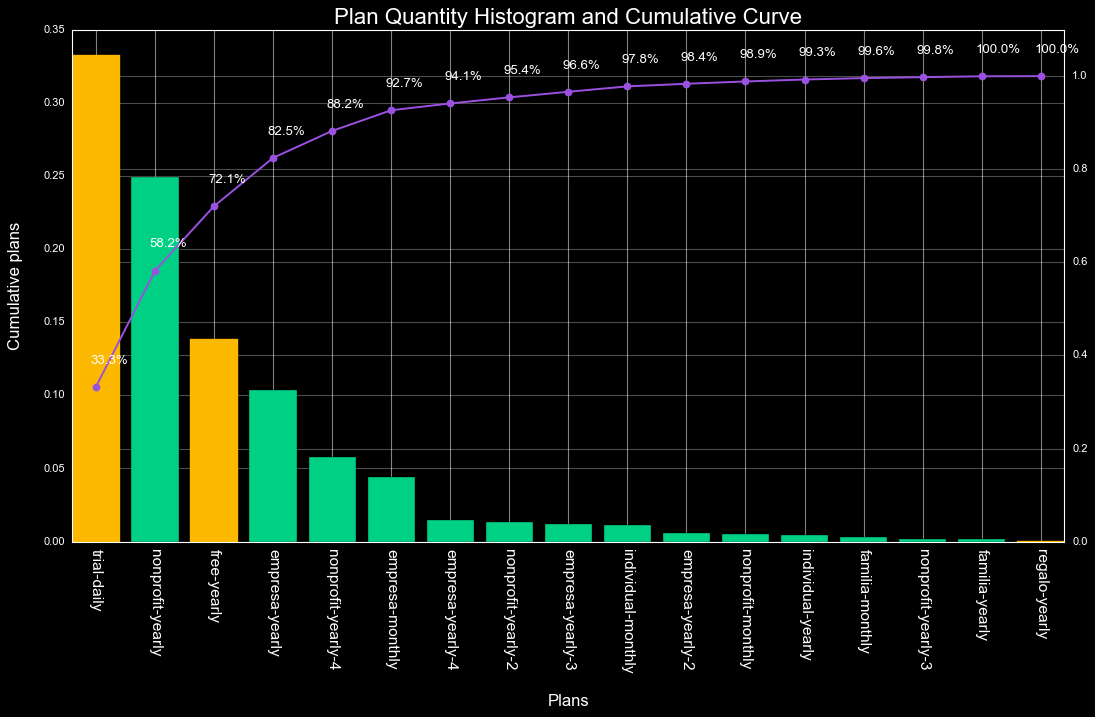

In [15]:
# generating figure and twin axes
plt.figure()
host = host_subplot(111)
par = host.twinx()

# we plot the bars (use host. instead of plt.)
x = np.array(plan_df['plan'])
y = np.array(plan_df['values_norm'])
p1 = host.bar(x, y)

# changing color for free plans
p1.patches[0].set_color("#fcb900")
p1.patches[2].set_color("#fcb900")
p1.patches[16].set_color("#fcb900")

# plotting the curve (use par. instead of plt.)
x = list(range(len(x)))
y = list(plan_df['perc_cumulative'])
p2 = par.plot(x, y, color="#9b51e0",marker='o')

# plotting the values from the cumulative curve on top of it
y_labels = list(plan_df['perc_cum_label'])
for i,j in zip(x,y):
    inplot = par.annotate(str(y_labels[i]), xy=(i-0.1,j+0.05), fontsize=12,
                          color='white')
    
# some final tweaking in title, axis and labels
par.axis(ymin=0, ymax=1.1)
plt.title('Plan Quantity Histogram and Cumulative Curve', fontsize=20)
host.set_xlabel('Plans', size=15, labelpad=18)
host.set_ylabel('Cumulative plans', size=15, labelpad=18)
host.tick_params(axis='x', labelsize = 14, labelrotation=-90)

# saving files to dir
plt.savefig(f"{graphs_dir}/Plan_quantity_cumulative_histogram_curve.png",
            bbox_inches = 'tight')
plt.show()

From the histogram, it's pretty clear that *trial-daily* has about 33% of plan quantity and if paired with *free-yearly* and *regalo-yearly* they would up to almost 50%.

I'll be doing peforming same excersice without the free accounts.


In [16]:
# Creating columns to reflect cumulative values (having removed free plans)
plan_nofree = pd.DataFrame(series_plan).reset_index()
plan_nofree = plan_nofree.drop([0, 2, 16]).reset_index()
plan_nofree = plan_nofree.drop("index", axis=1)
plan_nofree["values_norm"] = plan_nofree.plan_quantity / \
    plan_nofree.plan_quantity.sum()
plan_nofree["cumulative"] = plan_nofree.values_norm.cumsum()
plan_nofree["perc_cumulative"] = plan_nofree.cumulative / \
    plan_nofree.cumulative.max()
plan_nofree["perc_cum_label"] = plan_nofree.apply(
    lambda x: str(round(x.perc_cumulative * 100, 1)) + "%", axis=1)


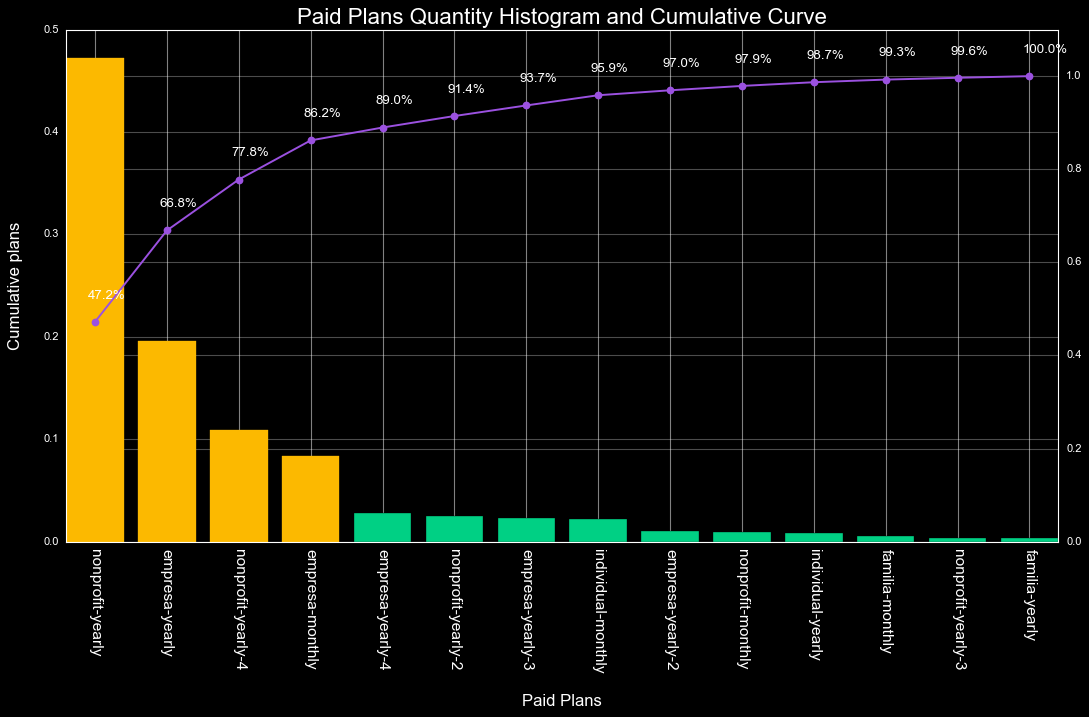

In [17]:
# generating figure and twin axes
plt.figure(figsize=(16, 8))
host = host_subplot(111)
par = host.twinx()

# we plot the bars (use host. instead of plt.)
x = np.array(plan_nofree['plan'])
y = np.array(plan_nofree['values_norm'])
p1 = host.bar(x, y)

# changing color for largest plans
p1.patches[0].set_color("#fcb900")
p1.patches[1].set_color("#fcb900")
p1.patches[2].set_color("#fcb900")
p1.patches[3].set_color("#fcb900")

# plotting the curve (use par. instead of plt.)
x = list(range(len(x)))
y = list(plan_nofree['perc_cumulative'])
p2 = par.plot(x, y, color="#9b51e0",marker='o')

# plotting the values from the cumulative curve on top of it
y_labels = list(plan_nofree['perc_cum_label'])
for i,j in zip(x,y):
    inplot = par.annotate(str(y_labels[i]), xy=(i-0.1,j+0.05), fontsize=12,
                          color='white')
    
# some final tweaking in title, axis and labels
par.axis(ymin=0, ymax=1.1)
plt.title('Paid Plans Quantity Histogram and Cumulative Curve', fontsize=20)
host.set_xlabel('Paid Plans', size=15, labelpad=18)
host.set_ylabel('Cumulative plans', size=15, labelpad=18)
host.tick_params(axis="x", labelsize = 14, labelrotation=-90)

# saving files to dir
plt.savefig(f"{graphs_dir}/Paid_Plans_quantity_cumulative_histogram_curve.png",
            bbox_inches = 'tight')
plt.show()

I'll plot stacked histograms to visualize status per plan for the four plans with more subscriptions.

In [18]:
series_plan = subs.groupby(["plan", "status"])["plan_quantity"].sum().\
    sort_values(
    ascending=False)

free_plans = ["trial-daily", "free-yearly", "regalo-yearly"]

# Creating new DF
plan_df = pd.DataFrame(series_plan).reset_index()

# Dropping free plans
for free in free_plans:
    plan_df = plan_df[plan_df.plan != free]

# Creating columns to reflect cumulative values
plan_df["values_norm"] = plan_df.plan_quantity / plan_df.plan_quantity.sum()
plan_df["cumulative"] = plan_df.values_norm.cumsum()
plan_df["perc_cumulative"] = plan_df.cumulative / plan_df.cumulative.max()
plan_df["perc_cum_label"] = plan_df.apply(
      lambda x: str(round(x.perc_cumulative * 100, 1)) + "%", axis=1)

#Dropping plans past 0.86 cumulative
top85 = plan_df[plan_df["cumulative"] <= 0.86]
top85[["plan", "status"]] = top85[["plan", "status"]].astype("category")
top85 = top85.groupby(["plan", "status"])["plan_quantity"].sum().fillna(0)
top85 = pd.DataFrame(top85).reset_index()

top85

C:\Users\pablo\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,plan,status,plan_quantity
0,empresa-monthly,active,2593.0
1,empresa-monthly,cancelled,0.0
2,empresa-yearly,active,5062.0
3,empresa-yearly,cancelled,1371.0
4,nonprofit-yearly,active,11827.0
5,nonprofit-yearly,cancelled,3576.0
6,nonprofit-yearly-4,active,3469.0
7,nonprofit-yearly-4,cancelled,0.0


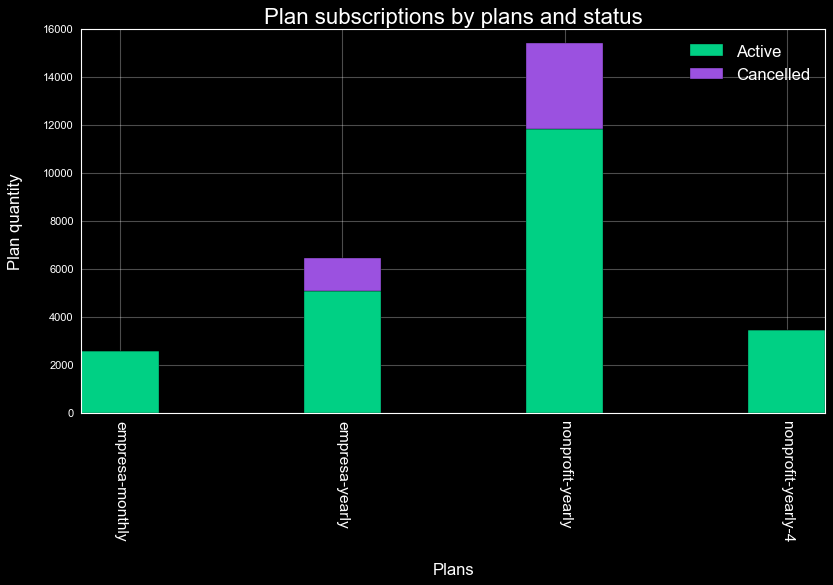

In [19]:
labels = top85.plan.unique().tolist()

active = top85["plan_quantity"][top85["status"] == "active"].to_list()
cancelled = top85["plan_quantity"][top85["status"] == "cancelled"].to_list()

# plotting the stacked histogram
fig, ax = plt.subplots(figsize=(12,6))

ax.bar(labels, active, width=0.35, label='Active')
ax.bar(labels, cancelled, width=0.35, bottom=active, label='Cancelled')

ax.set_ylabel('Plan quantity', fontsize=15, labelpad=18)
ax.set_xlabel('Plans', fontsize=15, labelpad=18)
ax.set_title('Plan subscriptions by plans and status', fontsize=20)
ax.tick_params(axis="x", labelsize = 14, labelrotation=-90)
ax.legend(fontsize=15)

plt.show()

#### SUBS TABLE BOXPLOTS

Boxplots will be drawn to compare plan unit prices between plans.

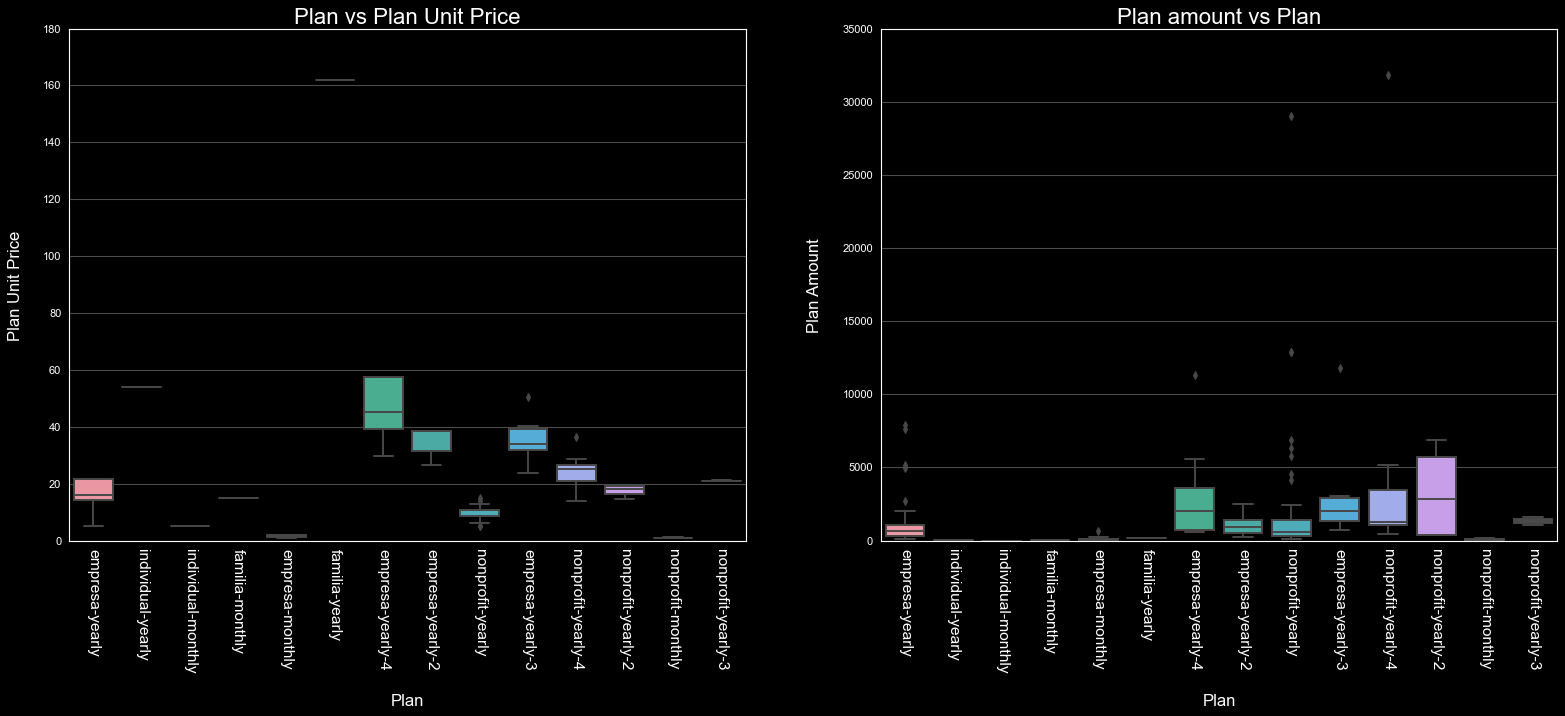

In [20]:
# Removing free plans of this calculation
boxplot_df = subs[subs.plan_unit_price != 0]

# setting up boxplot
fig, axs = plt.subplots(1, 2, figsize=(24,8))

sns.boxplot(x="plan", y="plan_unit_price", data=boxplot_df, ax=axs[0])
axs[0].tick_params(axis='x', labelsize = 14, labelrotation=-90)
axs[0].set_title('Plan vs Plan Unit Price', fontsize=20)
axs[0].set_xlabel("Plan", size=15, labelpad=18)
axs[0].set_ylabel("Plan Unit Price", size=15, labelpad=18)

sns.boxplot(x="plan", y="plan_amount", data=boxplot_df, ax=axs[1])
axs[1].tick_params(axis='x', labelsize = 14, labelrotation=-90)
axs[1].set_title('Plan amount vs Plan', fontsize=20)
axs[1].set_xlabel("Plan", size=15, labelpad=18)
axs[1].set_ylabel("Plan Amount", size=15, labelpad=18)

# saving files to dir
plt.savefig(f"{graphs_dir}/Plan_boxplots_1.png", bbox_inches = 'tight')

plt.show()


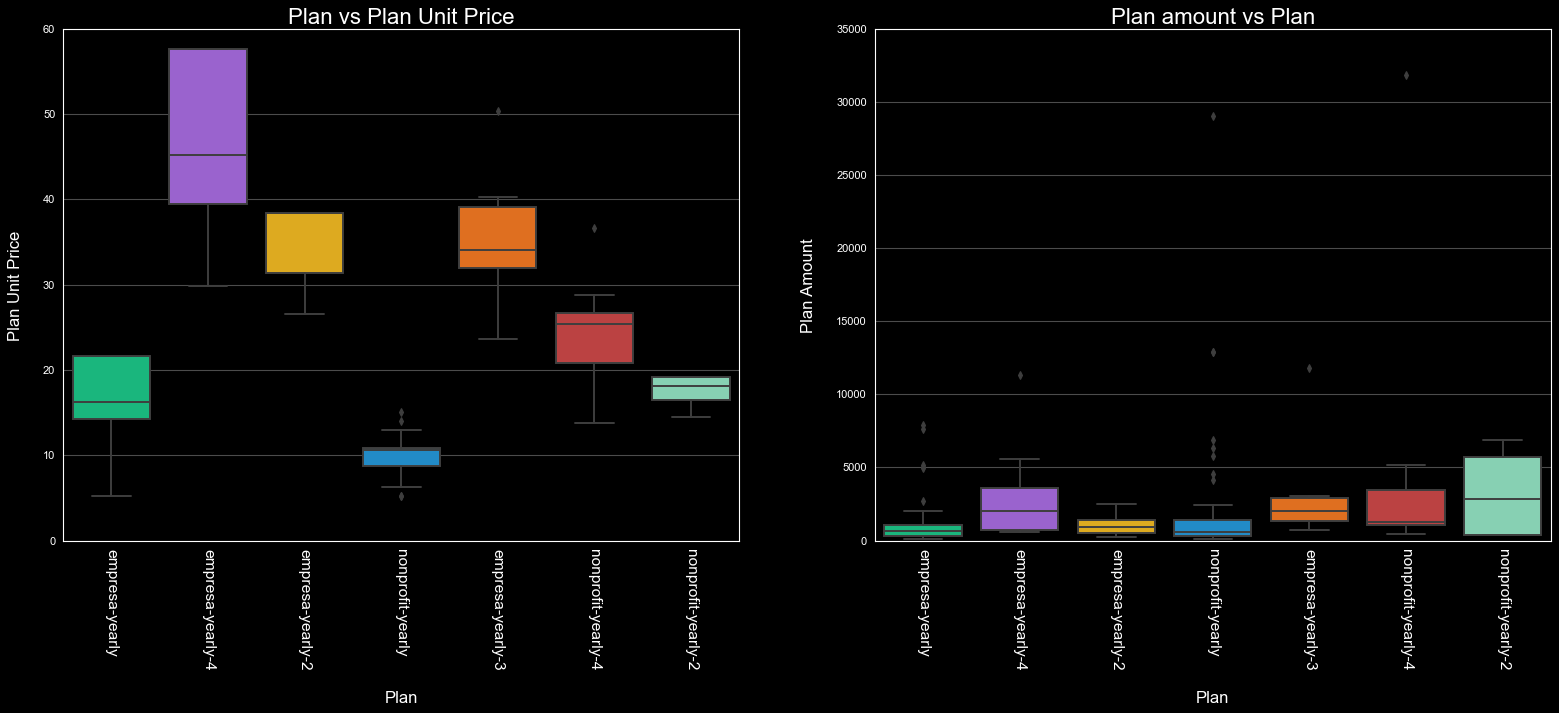

In [21]:
# Removing free plans of this calculation
boxplot_df2 = subs[subs.plan_unit_price != 0]

# removing plans with low variance
low_var = ["individual-yearly", "individual-monthly", "familia-monthly",
           "empresa-monthly", "familia-yearly", "nonprofit-monthly",
           "nonprofit-yearly-3"]

for plan in low_var:
    boxplot_df2 = boxplot_df2[boxplot_df2.plan != plan]

boxplot_df2.head(20)

# setting up boxplot
fig, axs = plt.subplots(1, 2, figsize=(24,8))

sns.boxplot(x="plan", y="plan_unit_price", data=boxplot_df2, ax=axs[0])
axs[0].tick_params(axis='x', labelsize = 14, labelrotation=-90)
axs[0].set_title('Plan vs Plan Unit Price', fontsize=20)
axs[0].set_xlabel("Plan", size=15, labelpad=18)
axs[0].set_ylabel("Plan Unit Price", size=15, labelpad=18)

sns.boxplot(x="plan", y="plan_amount", data=boxplot_df2, ax=axs[1])
axs[1].tick_params(axis='x', labelsize = 14, labelrotation=-90)
axs[1].set_title('Plan amount vs Plan', fontsize=20)
axs[1].set_xlabel("Plan", size=15, labelpad=18)
axs[1].set_ylabel("Plan Amount", size=15, labelpad=18)

# saving files to dir
plt.savefig(f"{graphs_dir}/Plan_boxplots_2.png", bbox_inches = 'tight')

plt.show()


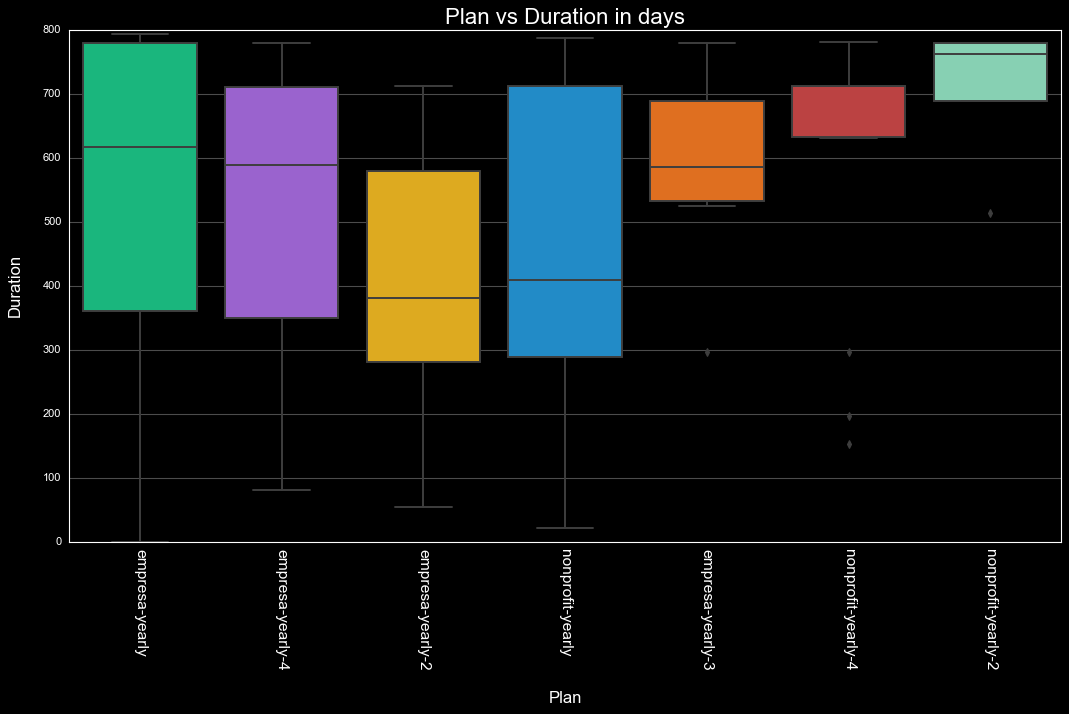

In [22]:
# # setting up boxplot for plan duration in days
boxplot_df3 = boxplot_df2
boxplot_df3["duration"] = boxplot_df3.duration.dt.days
fig = plt.figure()
ax = fig.gca()

sns.boxplot(x="plan", y="duration", data=boxplot_df3, ax=ax)
ax.tick_params(axis='x', labelsize = 14, labelrotation=-90)
ax.set_title('Plan vs Duration in days', fontsize=20)
ax.set_xlabel("Plan", size=15, labelpad=18)
ax.set_ylabel("Duration", size=15, labelpad=18)

# saving file to dir
plt.savefig(f"{graphs_dir}/Plan_boxplots_3.png", bbox_inches = 'tight')
plt.show()


## EXPLORATORY/VISUAL DATA ANALISYS: DVCS TABLE

### TL;DR DVCS TABLE EDA/VDA

Summary:
+ DVCS table has not a single NaN value on any of its colums.
+ **type**, **os** and **state** columns converted to categories type.
+ Generated histograms and boxplots to see data distribution.

In [23]:
# basic review of dvcs table
print(f"{dvcs.info()}\n\n{dvcs.head()})")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56240 entries, 0 to 56239
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          56240 non-null  object        
 1   user_id     56240 non-null  object        
 2   created_at  56240 non-null  datetime64[ns]
 3   type        56240 non-null  object        
 4   os          56240 non-null  object        
 5   state       56240 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 2.6+ MB
None

           id     user_id          created_at    type       os    state
0  b4ac4cfb6a  f76d3628cb 2013-02-12 13:46:37   Phone  Android  deleted
1  3740780237  f76d3628cb 2014-04-11 08:32:44  Tablet  Android  deleted
2  3a78940895  f76d3628cb 2014-04-19 14:52:01  Tablet  Android  deleted
3  74ab455a9d  f76d3628cb 2015-04-20 15:51:23   Phone  Android  deleted
4  400458972f  f76d3628cb 2016-06-21 10:56:59   Phone  Android  deleted)


In [24]:
# changing to category type
cols_to_cat = ["type", "os", "state"]
for col in dvcs.columns:
    if col in cols_to_cat:
        dvcs[col] = dvcs[col].astype("category")

print(dvcs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56240 entries, 0 to 56239
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          56240 non-null  object        
 1   user_id     56240 non-null  object        
 2   created_at  56240 non-null  datetime64[ns]
 3   type        56240 non-null  category      
 4   os          56240 non-null  category      
 5   state       56240 non-null  category      
dtypes: category(3), datetime64[ns](1), object(2)
memory usage: 1.4+ MB
None


Changing **type**, **os**, and **state** columns to category type reduced the memory usage from 2.6MB to 1.4MB. Memory saving might not be a big deal for such a reduced DataFrame object but it might come in handy it were to increase it's size.

In [25]:
# categories by size
print(f" type has {len(dvcs.type.unique())} categories\n os has {len(dvcs.os.unique())} \
categories\n state has {len(dvcs.state.unique())} categories")

# basic data distribution going from less to more categories
dvcs.groupby(["type", "state", "os"])[["user_id", "id"]].count()

 type has 4 categories
 os has 16 categories
 state has 4 categories


user_id   id
type    state      os                   
Desktop deleted    Android      NaN  NaN
                   Arch         NaN  NaN
                   Centos       1.0  1.0
                   Chrome       NaN  NaN
                   Debian       1.0  1.0
...                             ...  ...
Tablet  unverified Mint         NaN  NaN
                   Neon         NaN  NaN
                   Solus        NaN  NaN
                   Ubuntu       NaN  NaN
                   Windows      NaN  NaN

[256 rows x 2 columns]

From the *groupby* method I was expecting to find a different count between **id** and **user_id**, mostly having user_id < id, indicating that one user can have more than one device. Instead, the result shows that each user has one and only one device associated.

Having this into consideration, I'll will *groupby* again, just taking **id** into consideration.

In [26]:
dvcs_gb = dvcs.groupby(["type", "state", "os"])["id"].count()
dvcs_gb = pd.DataFrame(dvcs_gb).reset_index()
dvcs_gb.rename(columns={"id":"total"}, inplace=True)

dvcs_gb

,type,state,os,total
0,Desktop,deleted,Android,0
1,Desktop,deleted,Arch,0
2,Desktop,deleted,Centos,1
3,Desktop,deleted,Chrome,0
4,Desktop,deleted,Debian,1
...,...,...,...,...
251,Tablet,unverified,Mint,0
252,Tablet,unverified,Neon,0
253,Tablet,unverified,Solus,0
254,Tablet,unverified,Ubuntu,0
